# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Present the Data](#present)
* [Shop near by](#shop)
* [Analysis](#analysis)
* [Conclusion](#conclusion)

# Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for shoping store. Specifically, this report will be targeted to stakeholders interested in opening an **Clothing Store** in **Toronto**, Canada.

Since there are lots of shopping center in Toronto we will try to detect **locations that are not already crowded with shopping stores**. We are also particularly interested in **crime in the neighborhood**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.


# Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing shopping centers in the neighborhood (any type of restaurant)
* number of and distance to shopping center in the neighborhood, if any
* distance of neighborhood from city center
* crime rate (robery) of the neighborhood

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* List of neighborhood in Toronto (will use the previous data from week 3)
* number of shops and their type and location in every neighborhood will be obtained using **Foursquare API**
* Crime Data in Toronto https://opendata.arcgis.com/datasets/a5c96cea73974de0b25b20240e55f20b_0.geojson

## First we will imported all needed library

In [1]:
# import needed libraries
from bs4 import BeautifulSoup
import types
from botocore.client import Config
import ibm_boto3
#Before we get the data and start exploring it, let's download all the dependencies that we will need.

!conda install -c conda-forge geopy --yes        # if needed
!conda install -c conda-forge folium=0.5.0 --yes # if needed

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim 
GeoLocator = Nominatim(user_agent='My-IBMNotebook')# convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

## Scraping Data from Wikipedia for Neighborhood and Borough 

In [2]:
url = "https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods"
page = requests.get(url)
soup = BeautifulSoup(page.text,"html.parser")
tables = soup.findAll("table", class_='wikitable')[0]

In [3]:
#Create a data frame
column_names = ['Borough','Neighbourhood','Census Tracts','Population','Land area km2','Density people/km2','Percent Change in Population since 2001','Average Income','Transit Commuting','Renters','2nd most common language by name','2nd most common language by percentage','Map']
df_Toronto = pd.DataFrame(columns = column_names)
name = 0
borough=0 
census=0
population=0
land_area=0
density=0
percent_Change=0
income=0
transit=0
renters=0
language2_name=0
language2_percentage=0
Map=0

In [4]:
for tr_code in tables.find_all('tr'):
    i = 0
    for td_code in tr_code.find_all('td'):
        if i == 0:
            name = td_code.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 1:
            borough = td_code.text.strip('\n').replace(']','')
            if borough == 'OCoT':
                borough = 'Old City of Toronto'
            if borough == 'S':
                borough = 'Scarborough'
            if borough == 'NY':
                borough = 'North York'
            if borough == 'E':
                borough = 'Etobicoke'
            if borough == 'Y':
                borough = 'York'
            if borough == 'EY':
                borough = "East York"
            i = i + 1
        elif i == 2: 
            census = td_code.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 3:
            population = td_code.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 4:
            land_area = td_code.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 5:
            density = td_code.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 6:
            percent_Change = td_code.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 7:
            income = td_code.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 8:
            transit = td_code.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 9:
            renters = td_code.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 10:
            language2_name = td_code.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 11:
            language2_percentage = td_code.text.strip('\n').replace(']','')
            i = i + 1
        elif i == 12:
            Map = td_code.text
    df_Toronto = df_Toronto.append({'Borough':borough,'Neighbourhood':name,'Census Tracts':census,'Population':population,'Land area km2':land_area,'Density people/km2':density,'Percent Change in Population since 2001':percent_Change,'Average Income':income,'Transit Commuting':transit,'Renters':renters,'2nd most common language by name':language2_name,'2nd most common language by percentage':language2_percentage,'Map':Map},ignore_index=True)
    
df_Toronto.head()

,Borough,Neighbourhood,Census Tracts,Population,Land area km2,Density people/km2,Percent Change in Population since 2001,Average Income,Transit Commuting,Renters,2nd most common language by name,2nd most common language by percentage,Map
0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,,Toronto CMA Average,All,"5,113,149",5903.63,866,9.0,"40,704",10.6,11.4,,,\n
2,Scarborough,Agincourt,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...","44,577",12.45,3580,4.6,"25,750",11.1,5.9,Cantonese (19.3%),19.3% Cantonese,\n
3,Etobicoke,Alderwood,"0211.00, 0212.00","11,656",4.94,2360,-4.0,"35,239",8.8,8.5,Polish (6.2%),06.2% Polish,\n
4,Old City of Toronto,Alexandra Park,0039.00,"4,355",0.32,"13,609",0.0,"19,687",13.8,28.0,Cantonese (17.9%),17.9% Cantonese,\n


### Cleaning up the data

In [5]:
# Delete the rows with labels 0
df_Toronto = df_Toronto.drop([0], axis=0)

# We dont need the 1st row because we only need separate Neighborhood
df_Toronto = df_Toronto.drop([1], axis=0)

# We only need the Neighbourhood Name, Borough, Population, Density, and Average Income
df_Toronto = df_Toronto.drop(["Census Tracts", "Land area km2", "Percent Change in Population since 2001","Transit Commuting","Renters","2nd most common language by name","2nd most common language by percentage","Map"], axis=1)
df_Toronto.head()

,Borough,Neighbourhood,Population,Density people/km2,Average Income
2,Scarborough,Agincourt,"44,577",3580,"25,750"
3,Etobicoke,Alderwood,"11,656",2360,"35,239"
4,Old City of Toronto,Alexandra Park,"4,355","13,609","19,687"
5,Old City of Toronto,Allenby,"2,513",4333,"245,592"
6,North York,Amesbury,"17,318","4,934","27,546"


In [6]:
#Check the types of the dataframe
df_Toronto.dtypes

Borough               object
Neighbourhood         object
Population            object
Density people/km2    object
Average Income        object
dtype: object

In [7]:
#For the number in Population, Density, and Average Income to works, we need to change the type
df_Toronto['Population'] = df_Toronto['Population'].str.replace(",","").astype(float)
df_Toronto['Density people/km2'] = df_Toronto['Density people/km2'].str.replace(",","").astype(float)
df_Toronto['Average Income'] = df_Toronto['Average Income'].str.replace(",","").astype(float)
df_Toronto.head()

,Borough,Neighbourhood,Population,Density people/km2,Average Income
2,Scarborough,Agincourt,44577.0,3580.0,25750.0
3,Etobicoke,Alderwood,11656.0,2360.0,35239.0
4,Old City of Toronto,Alexandra Park,4355.0,13609.0,19687.0
5,Old City of Toronto,Allenby,2513.0,4333.0,245592.0
6,North York,Amesbury,17318.0,4934.0,27546.0


### Group data to have the same Borough for Neighbourhood, Population, Density and Average Income

In [8]:
#For Neighbourhood, we will list all the Neighbourhood in the same cell wil a ',' between each one
df_borough = df_Toronto.groupby(['Borough'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
df_borough.head()

,Borough,Neighbourhood
0,East York,"Crescent Town, Governor's Bridge/Bennington He..."
1,Etobicoke,"Alderwood, Centennial, Clairville, Eatonville,..."
2,North York,"Amesbury, Armour Heights, Banbury, Bathurst Ma..."
3,Old City of Toronto,"Alexandra Park, Allenby, Bay Street Corridor, ..."
4,Scarborough,"Agincourt, Bendale, Birch Cliff, Clairlea, Cli..."


In [9]:
#For population, we will do a combination
df_population = df_Toronto.groupby(['Borough'])['Population'].sum().reset_index()
df_population.set_index('Borough', inplace=True)
df_population.head()

,Population
Borough,
East York,112054.0
Etobicoke,313772.0
North York,621068.0
Old City of Toronto,624910.0
Scarborough,600715.0


In [10]:
#For density we will do a average 
df_density = df_Toronto.groupby(['Borough'])['Density people/km2'].mean().reset_index()
df_density.set_index('Borough', inplace=True)
df_density.head()

,Density people/km2
Borough,
East York,7072.833333
Etobicoke,3334.720000
North York,4674.400000
Old City of Toronto,9370.281250
Scarborough,3970.655172


In [11]:
#For Average Income we also will do an average
df_income = df_Toronto.groupby(['Borough'])['Average Income'].mean().reset_index()
df_income.set_index('Borough', inplace=True)
df_income

,Average Income
Borough,
East York,54604.000000
Etobicoke,43056.200000
North York,54389.925000
Old City of Toronto,58409.281250
Scarborough,30518.793103
York,38124.000000


In [12]:
#Merge 2 data frame together on Borough
df_popden = pd.merge(df_population,
                 df_density,
                 on='Borough')
df_popden

,Population,Density people/km2
Borough,,
East York,112054.0,7072.833333
Etobicoke,313772.0,3334.720000
North York,621068.0,4674.400000
Old City of Toronto,624910.0,9370.281250
Scarborough,600715.0,3970.655172
York,143255.0,5600.100000


## Crime data for Toronto

In [13]:
# The code was removed by Watson Studio for sharing.

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,ObjectId
0,-79.374847,43.660656,8440,GO-2015942657,2015-06-05T14:15:00.000Z,2015-06-05T15:41:00.000Z,Outside,1610,220,Robbery - Other,2015,June,5,156,Friday,15,2015.0,June,5.0,156.0,Friday,14,Robbery,D51,73,Moss Park (73),43.660656,-79.374847,1001
1,-79.222259,43.751030,8441,GO-2015942418,2015-06-02T15:00:00.000Z,2015-06-05T15:09:00.000Z,Other,1610,200,Robbery - Mugging,2015,June,5,156,Friday,15,2015.0,June,2.0,153.0,Tuesday,15,Robbery,D43,137,Woburn (137),43.751030,-79.222259,1002
2,-79.420914,43.663029,8445,GO-20151975524,2015-11-17T21:05:00.000Z,2015-11-17T22:18:00.000Z,Outside,1610,200,Robbery - Mugging,2015,November,17,321,Tuesday,22,2015.0,November,17.0,321.0,Tuesday,21,Robbery,D14,93,Dovercourt-Wallace Emerson-Junction (93),43.663029,-79.420914,1003
3,-79.381638,43.667374,8447,GO-20151976833,2015-11-18T05:23:00.000Z,2015-11-18T05:23:00.000Z,Commercial,1610,210,Robbery - Business,2015,November,18,322,Wednesday,5,2015.0,November,18.0,322.0,Wednesday,5,Robbery,D51,75,Church-Yonge Corridor (75),43.667374,-79.381638,1004
4,-79.313820,43.675320,8453,GO-20152102376,2015-12-08T12:10:00.000Z,2015-12-08T12:19:00.000Z,Outside,1610,220,Robbery - Other,2015,December,8,342,Tuesday,12,2015.0,December,8.0,342.0,Tuesday,12,Robbery,D55,64,Woodbine Corridor (64),43.675320,-79.313820,1005
5,-79.313820,43.675320,8454,GO-20152102376,2015-12-08T12:10:00.000Z,2015-12-08T12:19:00.000Z,Outside,1610,220,Robbery - Other,2015,December,8,342,Tuesday,12,2015.0,December,8.0,342.0,Tuesday,12,Robbery,D55,64,Woodbine Corridor (64),43.675320,-79.313820,1006
6,-79.313820,43.675320,8455,GO-20152102376,2015-12-08T12:10:00.000Z,2015-12-08T12:19:00.000Z,Outside,1610,220,Robbery - Other,2015,December,8,342,Tuesday,12,2015.0,December,8.0,342.0,Tuesday,12,Robbery,D55,64,Woodbine Corridor (64),43.675320,-79.313820,1007
7,-79.383110,43.661373,8458,GO-20152152428,2015-12-16T00:00:00.000Z,2015-12-16T04:57:00.000Z,Commercial,1610,200,Robbery - Mugging,2015,December,16,350,Wednesday,4,2015.0,December,16.0,350.0,Wednesday,0,Robbery,D52,75,Church-Yonge Corridor (75),43.661373,-79.383110,1008
8,-79.507225,43.715458,8460,GO-20152157652,2015-12-16T20:40:00.000Z,2015-12-16T23:52:00.000Z,Outside,1610,200,Robbery - Mugging,2015,December,16,350,Wednesday,23,2015.0,December,16.0,350.0,Wednesday,20,Robbery,D12,28,Rustic (28),43.715458,-79.507225,1009
9,-79.476700,43.655926,8481,GO-2015837591,2015-05-20T00:25:00.000Z,2015-05-20T00:27:00.000Z,Outside,1610,200,Robbery - Mugging,2015,May,20,140,Wednesday,0,2015.0,May,20.0,140.0,Wednesday,0,Robbery,D11,88,High Park North (88),43.655926,-79.476700,1010


In [14]:
df_toronto_crime = df_toronto_crime_full
df_toronto_crime.head()

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Lat,Long,ObjectId
0,-79.374847,43.660656,8440,GO-2015942657,2015-06-05T14:15:00.000Z,2015-06-05T15:41:00.000Z,Outside,1610,220,Robbery - Other,2015,June,5,156,Friday,15,2015.0,June,5.0,156.0,Friday,14,Robbery,D51,73,Moss Park (73),43.660656,-79.374847,1001
1,-79.222259,43.751030,8441,GO-2015942418,2015-06-02T15:00:00.000Z,2015-06-05T15:09:00.000Z,Other,1610,200,Robbery - Mugging,2015,June,5,156,Friday,15,2015.0,June,2.0,153.0,Tuesday,15,Robbery,D43,137,Woburn (137),43.751030,-79.222259,1002
2,-79.420914,43.663029,8445,GO-20151975524,2015-11-17T21:05:00.000Z,2015-11-17T22:18:00.000Z,Outside,1610,200,Robbery - Mugging,2015,November,17,321,Tuesday,22,2015.0,November,17.0,321.0,Tuesday,21,Robbery,D14,93,Dovercourt-Wallace Emerson-Junction (93),43.663029,-79.420914,1003
3,-79.381638,43.667374,8447,GO-20151976833,2015-11-18T05:23:00.000Z,2015-11-18T05:23:00.000Z,Commercial,1610,210,Robbery - Business,2015,November,18,322,Wednesday,5,2015.0,November,18.0,322.0,Wednesday,5,Robbery,D51,75,Church-Yonge Corridor (75),43.667374,-79.381638,1004
4,-79.313820,43.675320,8453,GO-20152102376,2015-12-08T12:10:00.000Z,2015-12-08T12:19:00.000Z,Outside,1610,220,Robbery - Other,2015,December,8,342,Tuesday,12,2015.0,December,8.0,342.0,Tuesday,12,Robbery,D55,64,Woodbine Corridor (64),43.675320,-79.313820,1005


In [15]:
#Drop unnecessary columns

df_toronto_crime.drop(columns=["X","Y","Index_","event_unique_id","occurrencedate","reporteddate","ucr_code","ucr_ext","offence","occurrencedayofyear","occurrencedayofweek","occurrencehour","MCI","Hood_ID","ObjectId","reportedmonth","reportedday","reporteddayofyear","reporteddayofweek","reportedhour","occurrenceyear","occurrencemonth","occurrenceday","Division"],inplace=True)
df_toronto_crime.head()

,premisetype,reportedyear,Neighbourhood,Lat,Long
0,Outside,2015,Moss Park (73),43.660656,-79.374847
1,Other,2015,Woburn (137),43.751030,-79.222259
2,Outside,2015,Dovercourt-Wallace Emerson-Junction (93),43.663029,-79.420914
3,Commercial,2015,Church-Yonge Corridor (75),43.667374,-79.381638
4,Outside,2015,Woodbine Corridor (64),43.675320,-79.313820


In [16]:
#remove number in parenthesis of column Neighbourhood
df_toronto_crime['Neighbourhood'] = df_toronto_crime['Neighbourhood'].apply(lambda x: x.split('(')[0])
df_toronto_crime.head()

,premisetype,reportedyear,Neighbourhood,Lat,Long
0,Outside,2015,Moss Park,43.660656,-79.374847
1,Other,2015,Woburn,43.751030,-79.222259
2,Outside,2015,Dovercourt-Wallace Emerson-Junction,43.663029,-79.420914
3,Commercial,2015,Church-Yonge Corridor,43.667374,-79.381638
4,Outside,2015,Woodbine Corridor,43.675320,-79.313820


In [17]:
#Group incident by Neighbourhood
crime_borough=df_toronto_crime.groupby(['Neighbourhood']).size().reset_index(name='Number of Crime')
crime_borough.head()

,Neighbourhood,Number of Crime
0,Agincourt North,162
1,Agincourt South-Malvern West,148
2,Alderwood,36
3,Annex,314
4,Banbury-Don Mills,70


In [18]:
# creating a blank series 
Type_new = pd.Series([]) 

In [19]:
#Assign Borough name from Toronto dataframe to Type_new
i=0
for neigh1 in crime_borough['Neighbourhood']:
    j=2
    for neigh2 in df_Toronto['Neighbourhood']:
        if neigh2 in neigh1:
            Type_new[i]=df_Toronto.loc[j,'Borough']
        j=j+1
    i=i+1

In [20]:
#Inserted the Type_new column to the crime_borough dataframe
crime_borough.insert(1, "Borough",Type_new)
#Drop the Neighbourhood column since we no longer needed it.
crime_borough.drop(columns=["Neighbourhood"],inplace=True)

In [21]:
#Group dataframe by Borough and sum the Crime Count
crime_borough.groupby(['Borough']).sum().reset_index()
crime_borough.head()

,Borough,Number of Crime
0,Scarborough,162
1,Scarborough,148
2,Etobicoke,36
3,NaN,314
4,North York,70


In [22]:
#Combine crime in the Borough and calculate means and total
crime_borough=crime_borough.groupby(by='Borough').agg({'Number of Crime': ['mean', 'sum']}).reset_index()
#Set Index to Borough
crime_borough.set_index('Borough', inplace=True)
crime_borough.head()

Number of Crime      
                               mean   sum
Borough                                  
East York                 51.000000   153
Etobicoke                 93.000000  1209
North York               106.520000  2663
Old City of Toronto      107.916667  2590
Scarborough              174.956522  4024

# Present the Data <a name="present"></a>

In [23]:
#import maplotlib 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches # import patches 
import seaborn as sns

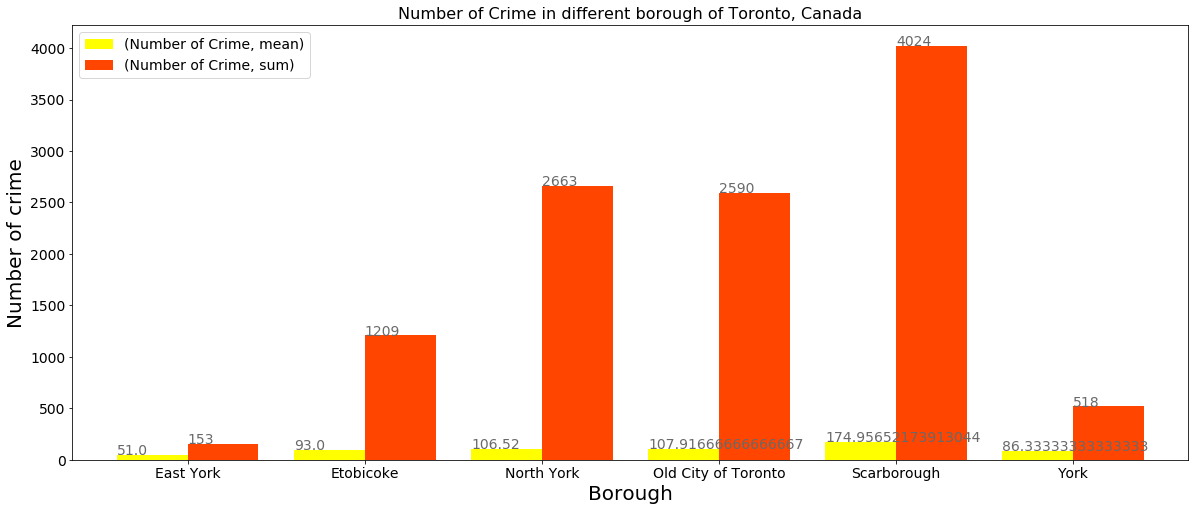

In [24]:
#Plot the data for crime
ax = crime_borough.plot(kind='bar', figsize=(20, 8),rot=90,width=0.8,color=['#FFFF00','#FF4500'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x, y/height*100 + height + 1, \
            str(height), fontsize=14,
                color='dimgrey')
plt.xticks(rotation=0,fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylabel("Number of crime",fontsize=20)
ax.set_xlabel("Borough",fontsize=20)
ax.set_title("Number of Crime in different borough of Toronto, Canada",fontsize=16)
ax.legend(fontsize=14)
plt.show()

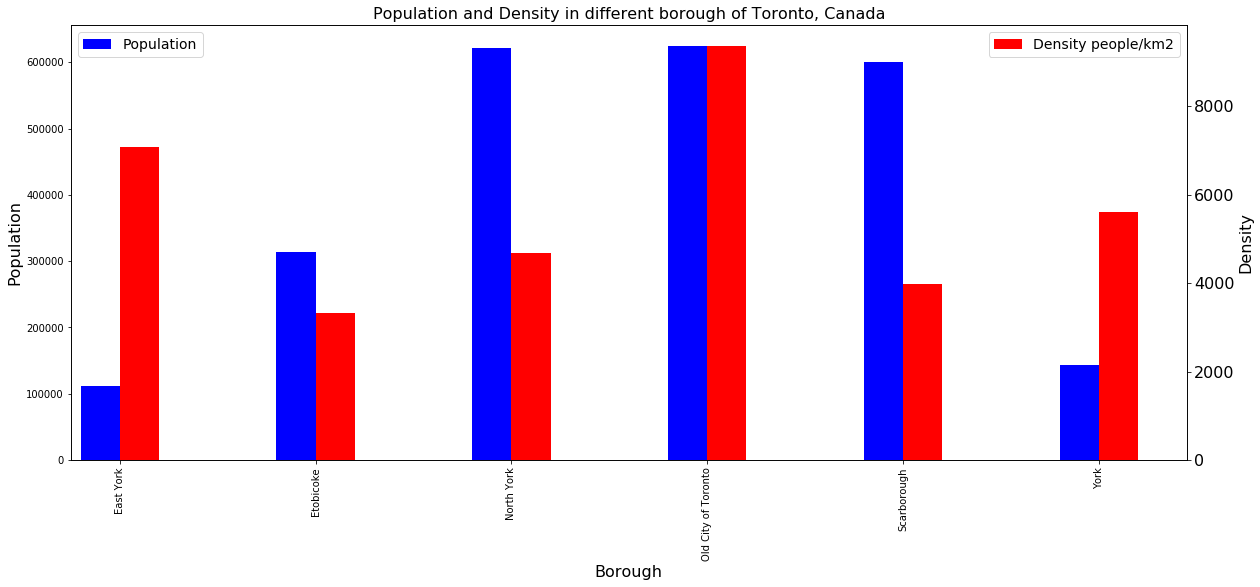

In [25]:
#Plot the data for population and density
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.2

df_population.plot(kind='bar', color='blue', figsize=(20, 8), ax=ax, width=width, position=1)
df_density.plot(kind='bar', color='red', figsize=(20, 8), ax=ax2, width=width, position=0)


plt.xticks(rotation=180, fontsize=14)
plt.yticks(fontsize=16)
ax.set_ylabel('Population', fontsize = 16)
ax2.set_ylabel('Density', fontsize = 16)
ax.set_xlabel("Borough",fontsize=16)
ax.set_title("Population and Density in different borough of Toronto, Canada",fontsize=16)
ax.legend(loc='upper left',fontsize=14)
ax2.legend(loc='upper right',fontsize=14)
plt.show()

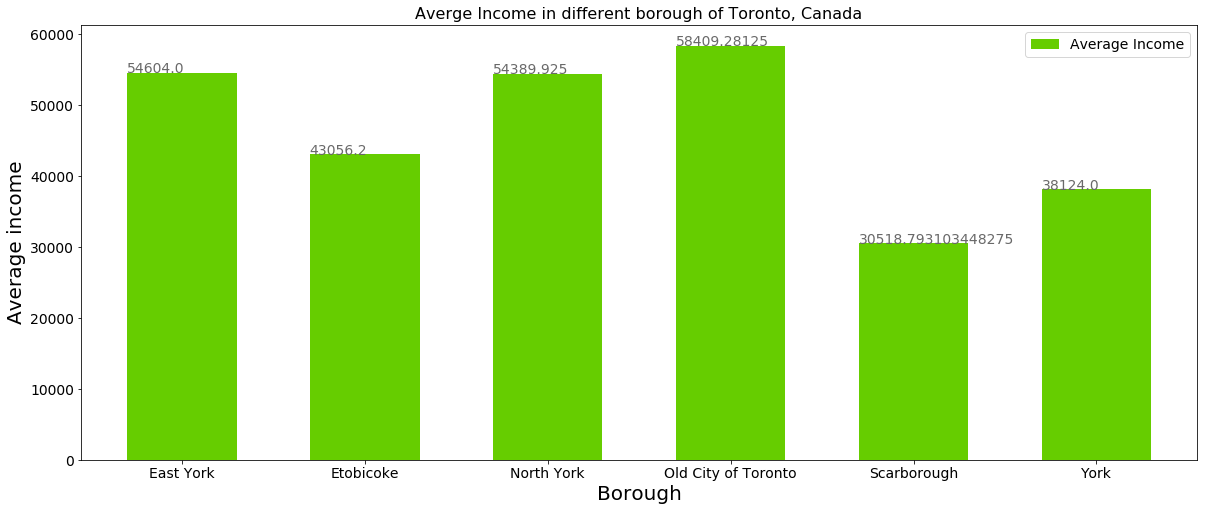

In [26]:
#Plot the data for average income
ax = df_income.plot(kind='bar', figsize=(20, 8),rot=90,width=0.6,color=['#66CD00'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x, y/height*100 + height + 1, \
            str(height), fontsize=14,
                color='dimgrey')
    
plt.xticks(rotation=0,fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylabel("Average income",fontsize=20)
ax.set_xlabel("Borough",fontsize=20)
ax.set_title("Averge Income in different borough of Toronto, Canada",fontsize=16)
ax.legend(fontsize=14)
plt.show()

## Create a map of Toronto with neighborhoods superimposed on top.

In [27]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude_toronto = location.latitude
longitude_toronto = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude_toronto, longitude_toronto))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [28]:
#Group by Neighbourhood and have the Lat and Long average
df_toronto_cor = df_toronto_crime.groupby(['Neighbourhood'])['Lat','Long'].mean().reset_index()
df_toronto_cor.head()

,Neighbourhood,Lat,Long
0,Agincourt North,43.806847,-79.273729
1,Agincourt South-Malvern West,43.786877,-79.273412
2,Alderwood,43.605114,-79.544731
3,Annex,43.668459,-79.406287
4,Banbury-Don Mills,43.733077,-79.341146


In [29]:
#Assign borough to coordinates database
Type_new = pd.Series([]) 
i=0
for neigh1 in df_toronto_cor['Neighbourhood']:
    j=2
    for neigh2 in df_Toronto['Neighbourhood']:
        if neigh2 in neigh1:
            Type_new[i]=df_Toronto.loc[j,'Borough']
        j=j+1
    i=i+1
    
#Inserted the Type_new column to the crime_borough dataframe
df_toronto_cor.insert(0, "Borough",Type_new)
df_toronto_cor.head()

,Borough,Neighbourhood,Lat,Long
0,Scarborough,Agincourt North,43.806847,-79.273729
1,Scarborough,Agincourt South-Malvern West,43.786877,-79.273412
2,Etobicoke,Alderwood,43.605114,-79.544731
3,NaN,Annex,43.668459,-79.406287
4,North York,Banbury-Don Mills,43.733077,-79.341146


In [30]:
df_toronto_cor.dtypes

Borough           object
Neighbourhood     object
Lat              float64
Long             float64
dtype: object

In [31]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude_toronto, longitude_toronto], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto_cor['Lat'], df_toronto_cor['Long'], df_toronto_cor['Borough'], df_toronto_cor['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto


In [32]:
#Group incident by Neighbourhood
crime_neigh=df_toronto_crime.groupby(['Neighbourhood']).size().reset_index(name='Number of Crime')
crime_neigh.head()

,Neighbourhood,Number of Crime
0,Agincourt North,162
1,Agincourt South-Malvern West,148
2,Alderwood,36
3,Annex,314
4,Banbury-Don Mills,70


In [33]:
#rank neighbourhood by number of crime 
crime_neigh.sort_values('Number of Crime',ascending=False)

,Neighbourhood,Number of Crime
23,Church-Yonge Corridor,904
80,Moss Park,630
82,Mount Olive-Silverstone-Jamestown,460
133,Woburn,429
125,West Humber-Clairville,376
139,York University Heights,370
63,Kensington-Chinatown,367
11,Bendale,347
123,Waterfront Communities-The Island,323
124,West Hill,323


In [102]:
# Add borough to the crime_neigh
# creating a blank series 
Type = pd.Series([]) 
#Assign Borough name from Toronto dataframe to Type_new
i=0
for neigh1 in crime_neigh['Neighbourhood']:
    j=2
    for neigh2 in df_Toronto['Neighbourhood']:
        if neigh2 in neigh1:
            Type[i]=df_Toronto.loc[j,'Borough']
        j=j+1
    i=i+1
#Inserted the Type_new column to the crime_borough dataframe
crime_neigh.insert(0, "Borough",Type)
crime_neigh.head()

,Borough,Neighbourhood,Number of Crime
0,Scarborough,Agincourt North,162
1,Scarborough,Agincourt South-Malvern West,148
2,Etobicoke,Alderwood,36
3,NaN,Annex,314
4,North York,Banbury-Don Mills,70


# Get Shops near by<a name="shop"></a>

## Define Foursquare Credentials and Version

In [41]:
# The code was removed by Watson Studio for sharing.

### Top 100 venues that are in Toronto within a radius of 500 meters.

In [42]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

### Function process all the neighborhoods in Toronto

In [71]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID']
    
    return(nearby_venues)

In [72]:
#run the above function on each neighborhood and create a new dataframe called Toronto_venues
Toronto_venues = getNearbyVenues(names=df_toronto_cor['Neighbourhood'],
                                   latitudes=df_toronto_cor['Lat'],
                                   longitudes=df_toronto_cor['Long']
                                  )

Agincourt North 
Agincourt South-Malvern West 
Alderwood 
Annex 
Banbury-Don Mills 
Bathurst Manor 
Bay Street Corridor 
Bayview Village 
Bayview Woods-Steeles 
Bedford Park-Nortown 
Beechborough-Greenbrook 
Bendale 
Birchcliffe-Cliffside 
Black Creek 
Blake-Jones 
Briar Hill-Belgravia 
Bridle Path-Sunnybrook-York Mills 
Broadview North 
Brookhaven-Amesbury 
Cabbagetown-South St.James Town 
Caledonia-Fairbank 
Casa Loma 
Centennial Scarborough 
Church-Yonge Corridor 
Clairlea-Birchmount 
Clanton Park 
Cliffcrest 
Corso Italia-Davenport 
Danforth 
Danforth East York 
Don Valley Village 
Dorset Park 
Dovercourt-Wallace Emerson-Junction 
Downsview-Roding-CFB 
Dufferin Grove 
East End-Danforth 
Edenbridge-Humber Valley 
Eglinton East 
Elms-Old Rexdale 
Englemount-Lawrence 
Eringate-Centennial-West Deane 
Eringate-Centennial_West Deane 
Etobicoke West Mall 
Flemingdon Park 
Forest Hill North 
Forest Hill South 
Glenfield-Jane Heights 
Greenwood-Coxwell 
Guildwood 
Henry Farm 
High Park Nort

In [73]:
Toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,Agincourt North,43.806847,-79.273729,Menchie's,43.808338,-79.268288,Ice Cream Shop,4bf58dd8d48988d1c9941735
1,Agincourt North,43.806847,-79.273729,Booster Juice,43.809915,-79.269382,Juice Bar,4bf58dd8d48988d112941735
2,Agincourt North,43.806847,-79.273729,Shoppers Drug Mart,43.808894,-79.269854,Pharmacy,4bf58dd8d48988d10f951735
3,Agincourt North,43.806847,-79.273729,Dollarama,43.808889,-79.268889,Discount Store,52dea92d3cf9994f4e043dbb
4,Agincourt North,43.806847,-79.273729,Pizza Pizza,43.808318,-79.268537,Pizza Place,4bf58dd8d48988d1ca941735


In [74]:
#We interested in the shopping in Clothing Store category 
clothe_id = '4bf58dd8d48988d103951735' #id obtain from https://developer.foursquare.com/docs/resources/categories

In [101]:
# Drop all row that not is a clothing store category 
clothe_filtered = Toronto_venues[Toronto_venues['Venue ID'] == clothe_id]
clothe_filtered

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
123,Bay Street Corridor,43.654595,-79.384203,UNIQLO ユニクロ,43.655910,-79.380641,Clothing Store,4bf58dd8d48988d103951735
126,Bay Street Corridor,43.654595,-79.384203,Nordstrom,43.655041,-79.380966,Clothing Store,4bf58dd8d48988d103951735
159,Bay Street Corridor,43.654595,-79.384203,Roots,43.653613,-79.380244,Clothing Store,4bf58dd8d48988d103951735
174,Bay Street Corridor,43.654595,-79.384203,Hollister Co.,43.654480,-79.380914,Clothing Store,4bf58dd8d48988d103951735
187,Bay Street Corridor,43.654595,-79.384203,Magic Tailor,43.653742,-79.379745,Clothing Store,4bf58dd8d48988d103951735
201,Bay Street Corridor,43.654595,-79.384203,Abercrombie & Fitch,43.652915,-79.380495,Clothing Store,4bf58dd8d48988d103951735
206,Bay Street Corridor,43.654595,-79.384203,Urban Outfitters,43.654411,-79.380055,Clothing Store,4bf58dd8d48988d103951735
351,Casa Loma,43.681461,-79.415324,Joe Fresh,43.683531,-79.416407,Clothing Store,4bf58dd8d48988d103951735
379,Church-Yonge Corridor,43.658421,-79.380342,UNIQLO ユニクロ,43.655910,-79.380641,Clothing Store,4bf58dd8d48988d103951735
417,Church-Yonge Corridor,43.658421,-79.380342,Nordstrom,43.655041,-79.380966,Clothing Store,4bf58dd8d48988d103951735


In [81]:
clothe_filtered.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
Neighbourhood,,,,,,,
Bay Street Corridor,7,7,7,7,7,7,7
Casa Loma,1,1,1,1,1,1,1
Church-Yonge Corridor,3,3,3,3,3,3,3
Dufferin Grove,2,2,2,2,2,2,2
Mount Pleasant West,1,1,1,1,1,1,1
South Parkdale,1,1,1,1,1,1,1
South Riverdale,1,1,1,1,1,1,1
The Beaches,1,1,1,1,1,1,1
Trinity-Bellwoods,1,1,1,1,1,1,1


In [86]:
# How many unique categories can be curated from all the returned venues
print('There are {} clothing stores in Toronto.'.format((clothe_filtered['Venue Category'].count())))

There are 18 clothing stores in Toronto.


In [77]:
# Check how many venues were returned for each neighborhood
Toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
Neighbourhood,,,,,,,
Agincourt North,14,14,14,14,14,14,14
Agincourt South-Malvern West,22,22,22,22,22,22,22
Alderwood,7,7,7,7,7,7,7
Annex,35,35,35,35,35,35,35
Banbury-Don Mills,30,30,30,30,30,30,30
Bathurst Manor,4,4,4,4,4,4,4
Bay Street Corridor,100,100,100,100,100,100,100
Bayview Village,11,11,11,11,11,11,11
Bayview Woods-Steeles,2,2,2,2,2,2,2


In [78]:
# How many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 292 uniques categories.


## Analyze each neighbourhood

In [87]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighbourhood'] = Toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,

In [88]:
Toronto_onehot.shape

(2640, 293)

In [89]:
# Add borough to the Toronto_onehot
# creating a blank series 
Type = pd.Series([]) 
#Assign Borough name from Toronto dataframe to Type_new
i=0
for neigh1 in Toronto_onehot['Neighbourhood']:
    j=2
    for neigh2 in df_Toronto['Neighbourhood']:
        if neigh2 in neigh1:
            Type[i]=df_Toronto.loc[j,'Borough']
        j=j+1
    i=i+1
#Inserted the Type_new column to the crime_borough dataframe
Toronto_onehot.insert(0, "Borough",Type)
Toronto_onehot.head()

,Borough,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,

In [90]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
Toronto_grouped = Toronto_onehot.groupby('Neighbourhood').mean().reset_index()
Toronto_grouped

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,

In [91]:
Toronto_grouped.shape

(139, 293)

In [92]:
# group rows by Borough and by taking the mean of the frequency of occurrence of each category
Borough_grouped = Toronto_onehot.groupby('Borough').mean().reset_index()
Borough_grouped

,Borough,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Churrascaria,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift

In [93]:
Borough_grouped.shape

(6, 293)

In [94]:
# print each neighborhood along with the top 5 most common venues

num_top_venues = 5

for hood in Toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt North ----
                 venue  freq
0  Sporting Goods Shop  0.07
1     Video Game Store  0.07
2             Pharmacy  0.07
3       Discount Store  0.07
4    Convenience Store  0.07


----Agincourt South-Malvern West ----
                  venue  freq
0    Chinese Restaurant  0.41
1  Cantonese Restaurant  0.09
2         Shopping Mall  0.09
3     Korean Restaurant  0.05
4            Restaurant  0.05


----Alderwood ----
               venue  freq
0        Pizza Place  0.29
1  Convenience Store  0.14
2           Pharmacy  0.14
3       Skating Rink  0.14
4        Coffee Shop  0.14


----Annex ----
                           venue  freq
0  Vegetarian / Vegan Restaurant  0.06
1                         Bakery  0.06
2                            Pub  0.06
3                     Restaurant  0.06
4               Sushi Restaurant  0.06


----Banbury-Don Mills ----
                 venue  freq
0  American Restaurant  0.07
1        Women's Store  0.07
2          Pizza Place  0.07
3 

#### Function to sort the venues in descending order.

In [96]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Create the new dataframe and display the top 10 venues for each neighborhood.

In [97]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = Toronto_grouped['Neighbourhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)


print (neighbourhoods_venues_sorted.shape)
neighbourhoods_venues_sorted.head()

(139, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Ice Cream Shop,Bakery,Japanese Restaurant,Juice Bar,Movie Theater,Discount Store,Pharmacy,Convenience Store,Chinese Restaurant,Sporting Goods Shop
1,Agincourt South-Malvern West,Chinese Restaurant,Cantonese Restaurant,Shopping Mall,Noodle House,Restaurant,Bank,Food Court,Hong Kong Restaurant,Korean Restaurant,Vietnamese Restaurant
2,Alderwood,Pizza Place,Coffee Shop,Pharmacy,Convenience Store,Donut Shop,Skating Rink,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant
3,Annex,Vegetarian / Vegan Restaurant,Bakery,Restaurant,Sushi Restaurant,Pub,Beer Bar,Tea Room,Japanese Restaurant,Coffee Shop,Korean Restaurant
4,Banbury-Don Mills,Women's Store,American Restaurant,Restaurant,Pizza Place,Ice Cream Shop,Boutique,Jewelry Store,Sushi Restaurant,Supermarket,Chocolate Shop


#### Create the new dataframe and display the top 10 venues for each Borough

In [98]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Boroughs_venues_sorted = pd.DataFrame(columns=columns)
Boroughs_venues_sorted['Borough'] = Borough_grouped['Borough']

for ind in np.arange(Borough_grouped.shape[0]):
    Boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Borough_grouped.iloc[ind, :], num_top_venues)


print (Boroughs_venues_sorted.shape)
Boroughs_venues_sorted.head(6)

(6, 11)


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East York,Indian Restaurant,Bakery,Coffee Shop,Asian Restaurant,Turkish Restaurant,Pizza Place,Pharmacy,Bus Line,Restaurant,Sushi Restaurant
1,Etobicoke,Coffee Shop,Pizza Place,Convenience Store,Indian Restaurant,Park,Italian Restaurant,Hotel,Café,Pharmacy,Beer Store
2,North York,Coffee Shop,Fast Food Restaurant,Pizza Place,Park,Japanese Restaurant,Restaurant,Sandwich Place,Bank,Bakery,Pharmacy
3,Old City of Toronto,Coffee Shop,Café,Italian Restaurant,Park,Bar,Bakery,Pizza Place,Restaurant,Sandwich Place,Pub
4,Scarborough,Chinese Restaurant,Pizza Place,Fast Food Restaurant,Coffee Shop,Pharmacy,Sandwich Place,Electronics Store,Grocery Store,Park,Bakery
5,York,Coffee Shop,Pizza Place,Park,Café,Burger Joint,Vietnamese Restaurant,Fast Food Restaurant,Train Station,Light Rail Station,Taco Place


# Analysis <a name="analysis"></a>

First, using the **Crime** data, you want your shop at the location with at low crime rate as possible.
This means we will eliminate **~~Scarborough~~** for place to open new shop. 

Then, we want to use the **Density** of population for shop location since we wants most exposure for the shop. 
This means we will consider: **York**, **East York**, and **Old City of Toronto**

Then, we consider between the 3, where is the money at!
**East York** and **Old City of Toronto** have higher average income. So we will eliminate the **~~York~~**

Next, we consider the number shop around each borough, we only consider the **East York** and **Old City of Toronto**.

Using FourSquare, we obtain that the lack of Data from Wikipedia so we can not assign the Borough to the neighborhoud. 

We only have 18 clothing stores in Toronto. So there will be not a lot of compatition.  

Dive in a little more to the neighbourhood. We take the crime data base and added the borough. We only interested in the **East York** and **Old City of Toronto**

In [110]:
# create east york neighbourhood crime data base  
crime_eastyork = crime_neigh[crime_neigh['Borough'] == "East York"]
crime_eastyork.sort_values('Number of Crime')

,Borough,Neighbourhood,Number of Crime
71,East York,Leaside-Bennington,47
94,East York,Old East York,51
119,East York,Thorncliffe Park,55


In [109]:
# create Old City of Toronto neighbourhood crime data base  
crime_oldcity = crime_neigh[crime_neigh['Borough'] == "Old City of Toronto"]
crime_oldcity.sort_values('Number of Crime')

,Borough,Neighbourhood,Number of Crime
45,Old City of Toronto,Forest Hill South,12
69,Old City of Toronto,Lawrence Park North,18
70,Old City of Toronto,Lawrence Park South,27
21,Old City of Toronto,Casa Loma,34
72,Old City of Toronto,Little Portugal,42
88,Old City of Toronto,Niagara,55
44,Old City of Toronto,Forest Hill North,56
136,Old City of Toronto,Wychwood,66
51,Old City of Toronto,High Park-Swansea,71
98,Old City of Toronto,Playter Estates-Danforth,73


# Conclusion <a name="conclusion"></a>

The purpose of this project is to fine the best location for opening a clothing store in Toronto, Canada. 
Using the data crime data, neighbourhood and Foursquare location. Wee see that there are not a lot of clothing store in Toronto. 
So the best decision is located the store where it will be safe and have a lot of customer. 

**East York** and **Old City of Toronto** all have very optimal location. 

Using simple sorted value, we can see the best 2 Neighbourhood for each are: 
**Forest Hill South,Old City of Toronto**